# Практические задания по цифровой обработке сигналов
# Вторая лабораторная работа
# Анализ сигналов

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

In [2]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()

In [3]:
# Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования
signals = {}

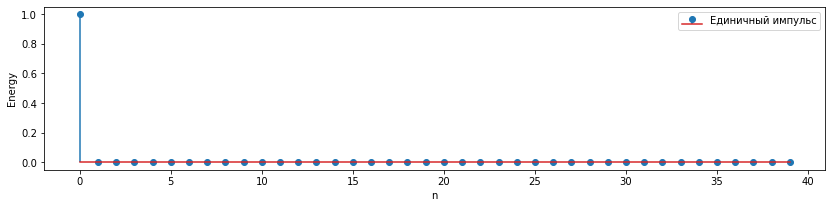

In [4]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

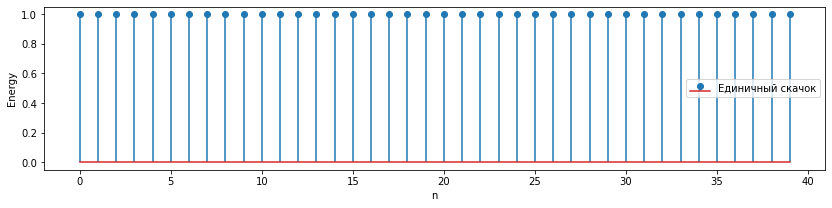

In [5]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

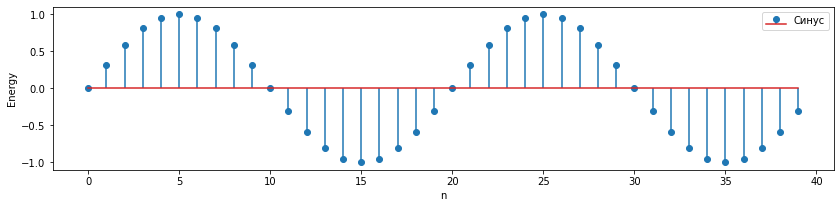

In [6]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

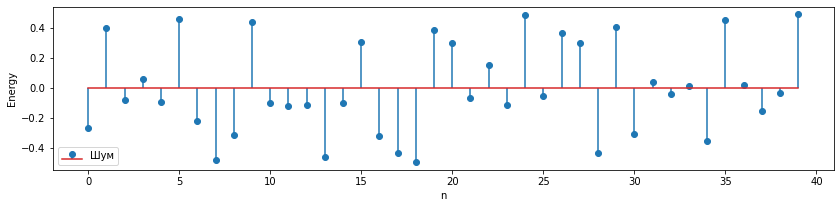

In [7]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT)):
$$ X_k = \sum_{n=0}^{N-1} x_n * e^{2i\pi k n/N} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией scipy.fft.fft

In [8]:
def DFT(x):
    
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    dft_value = np.dot(x, np.exp(-2j * np.pi * k * n / N))
    
    return dft_value

In [9]:
def test_DTF(x, transform=DFT):
    # Сравнение с библиотекой scipy
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

In [10]:
def FFT(x):
    
    # размер сигнала
    N = len(x)
    
    if N == 1:
        return x
    # получается, что x не может меньше быть меньшей длины, чем 32 для быстрого преобразования Фурье
    elif N <= 32:
        return DFT(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        terms = np.exp(-2j * np.pi * np.arange(N) / N)
        fft_value = np.concatenate([X_even + terms[:int(N / 2)] * X_odd, X_even + terms[int(N / 2):] * X_odd])

        return fft_value

In [11]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [12]:
# функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    
    return np.abs(spec)

# функция построения фазового спектра
def get_phi_from_spec(spec):
    
    return np.angle(spec)

In [13]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong magnitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  magnitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong magnitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong magnitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong phase. Make sure it is an angle."

   
print("All OK!")

All OK!


In [14]:
# Определим еще одну функцию для отрисовки
# Теперь будем рисовать сигнал в частотной области
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Magnitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

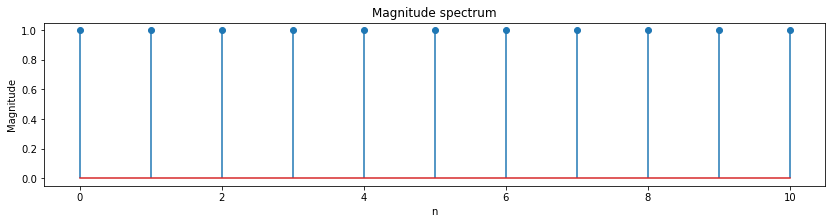

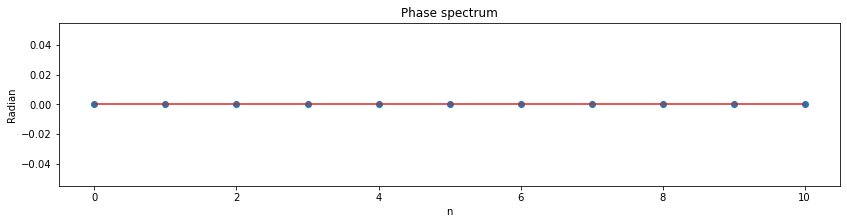

In [15]:
_spec = scipy.fft.fft(np.array([1]+[0]*10))
draw_spec(_spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3))

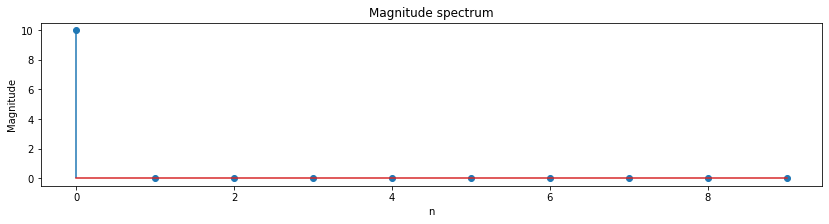

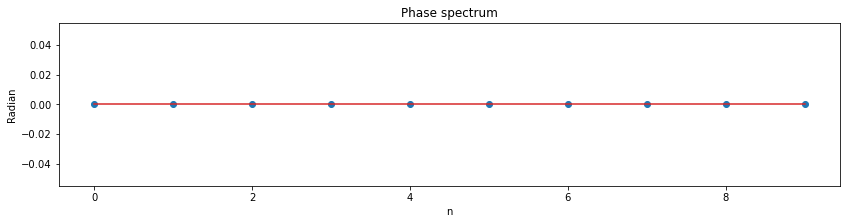

In [16]:
_spec = scipy.fft.fft(np.array([1]*10))
draw_spec(_spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3))

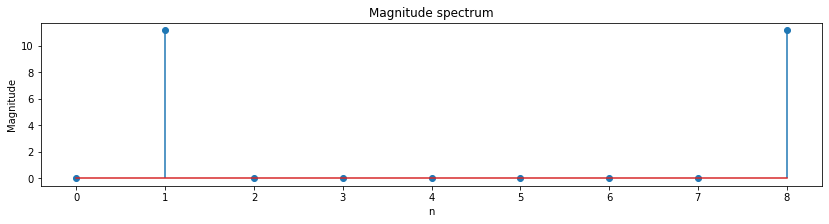

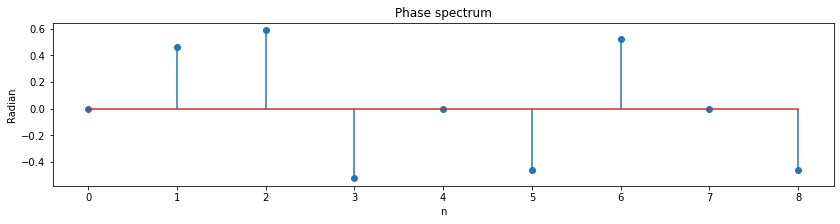

In [17]:
_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
draw_spec(_spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3))

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
1. Почему амплитуда всех гармоник единичного импульса равна константе? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

1. Так как спектр этого сигнала равномерно распределен в бесконечной полосе частот
2. Фазовый спектр сигнала – это совокупность начальных фаз всех гармоник (шумоподобный сигнал), а амплитудный спект - амплитуды всех гармоник, из которых складывается сигнал, в котором хранится полезная информация для анализа (речь, тон, кто говорил);
3. частота дискретизации / 2 =  номер отсчета / 2;
4. Шум - это представление в частотной области случайных изменений фаз сигнала, соответствующих отклонениям во временной области от идеального сигнала, а полезная информация - разброс задержки сигнала и дисперсия.

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье, пользуясь только библиотеками numpy и scipy. Сравнить с librosa.stft


In [18]:
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    #  Short-time Fourier transform
    # x - signal
    # n_fft - fft window size 
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram 
    
    w = scipy.signal.get_window(window, n_fft, fftbins=True)
    N = len(w)
    x = np.pad(x, int(n_fft // 2), mode='reflect')
    L = len(x)
    M = np.floor((L - N) / hop_length).astype(int) + 1
    X = np.zeros((N, M), dtype='complex')
    for m in range(M):
        x_win = x[m * hop_length:m * hop_length + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win[:X.shape[0]]
        
    return X[:int(1 + n_fft // 2)]

In [19]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


In [20]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

Checking 'Единичный импульс'


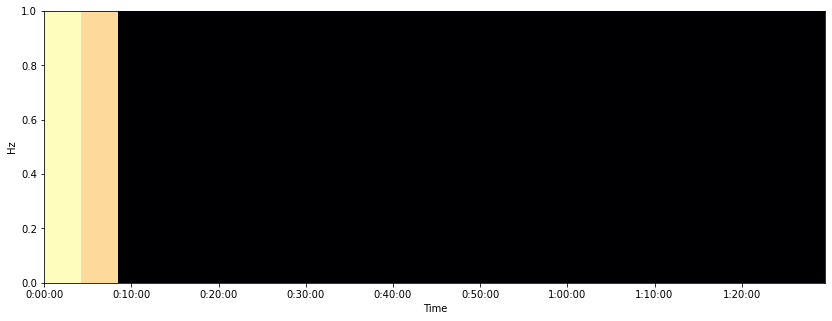

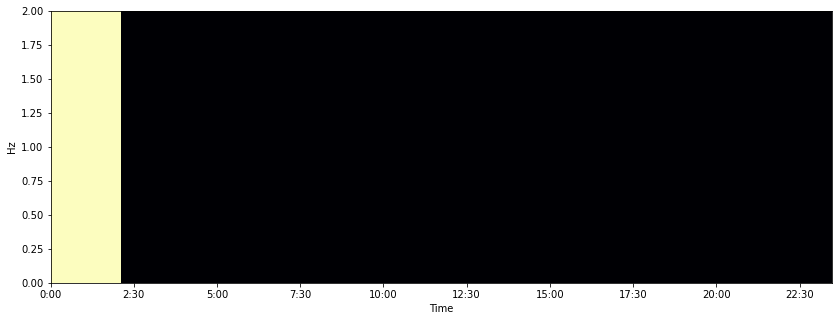

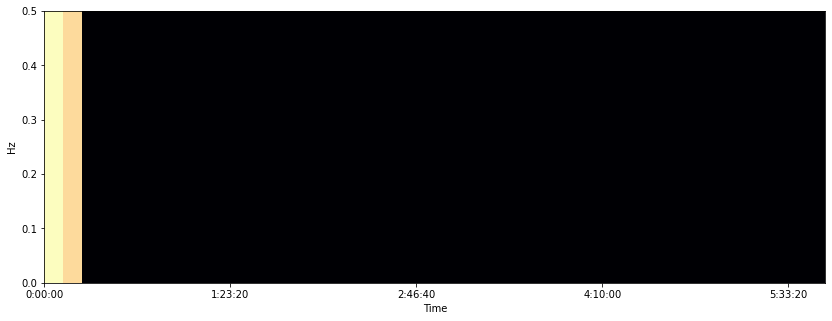

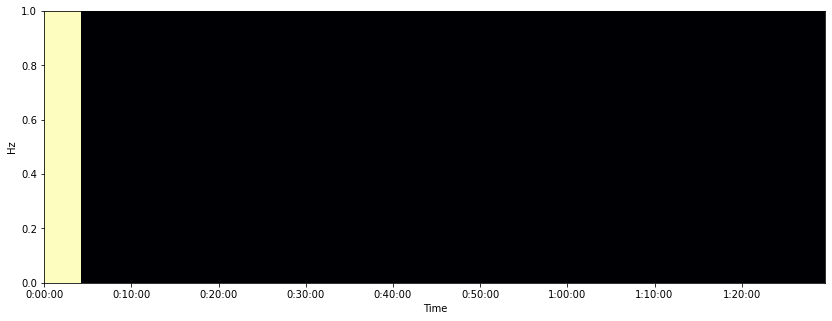

Checking 'Единичный скачок'


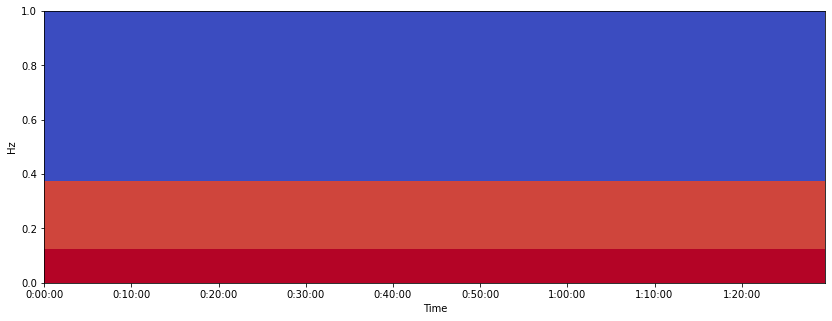

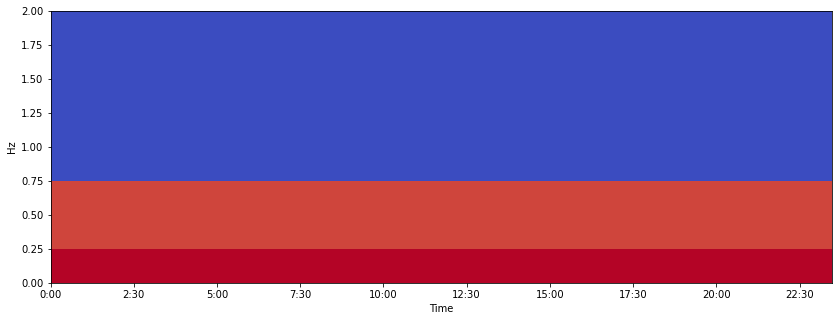

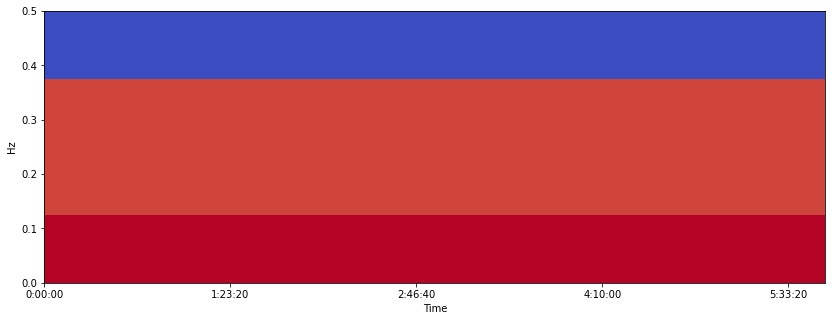

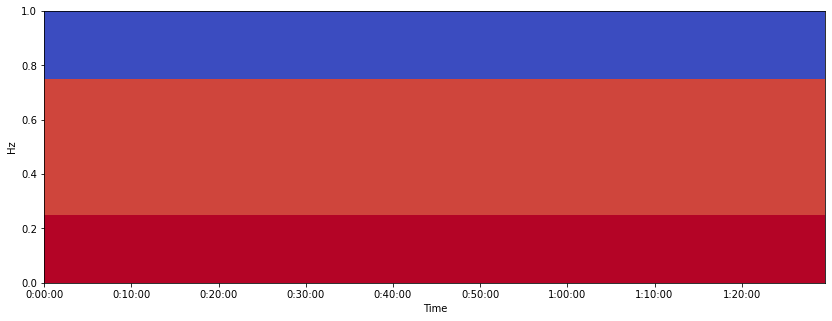

Checking 'Синус'


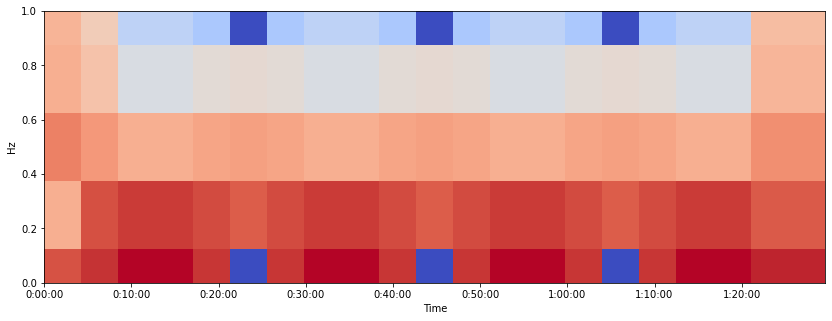

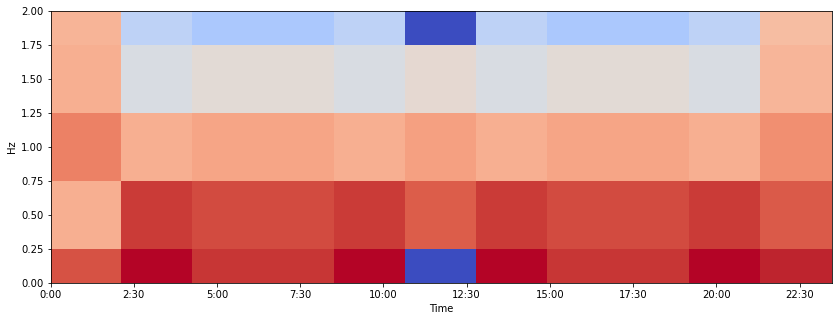

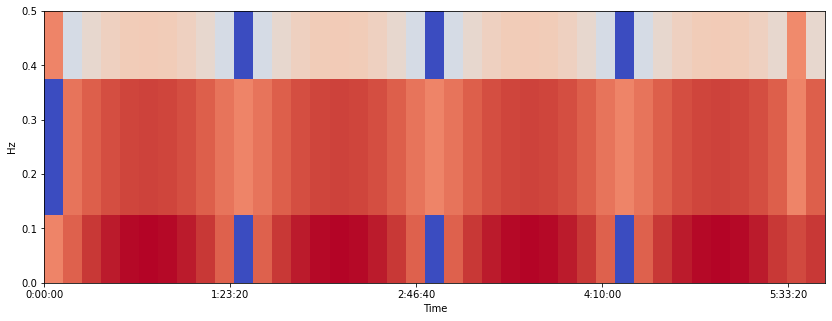

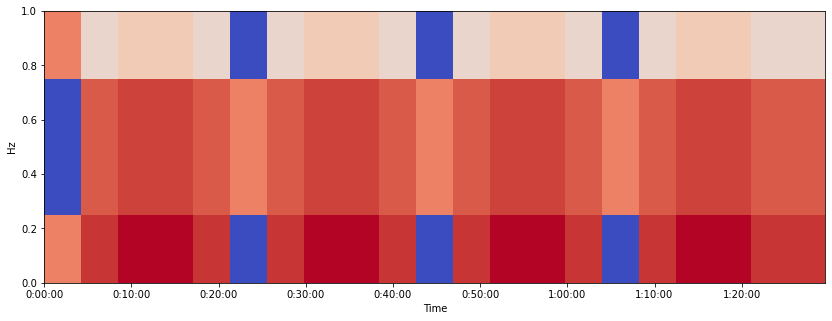

Checking 'Шум'


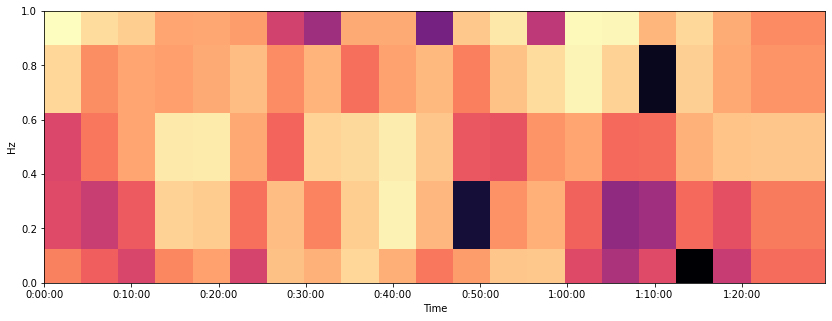

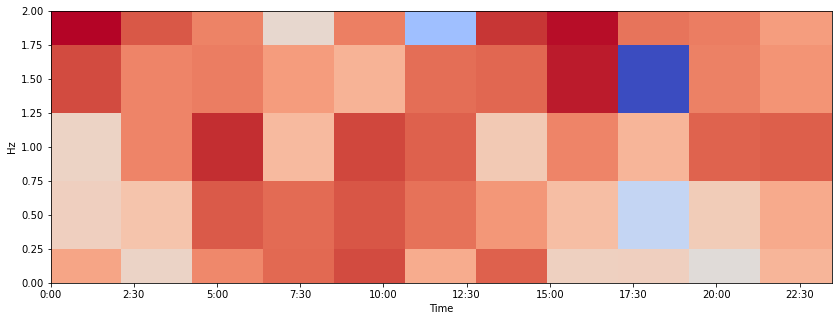

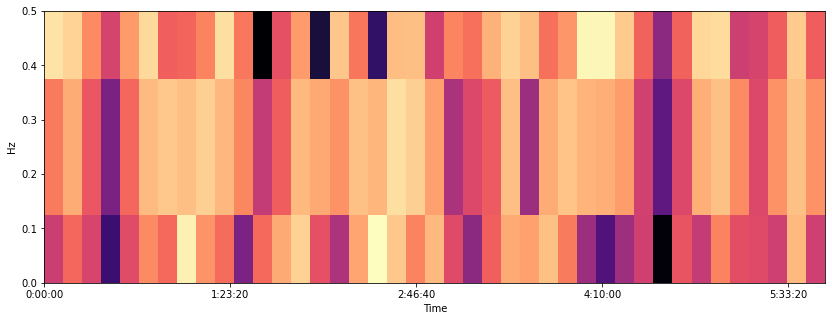

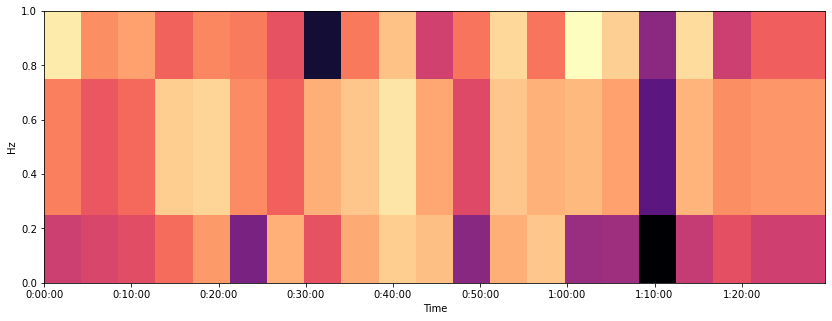

In [21]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            result = STFT(sig, n_fft=n_fft, hop_length=hop_length, window='hann')
            draw_stft(result, sr=hop_length, figsize=(14, 5))

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Len is 82175 ( ). Sample rate is 22050


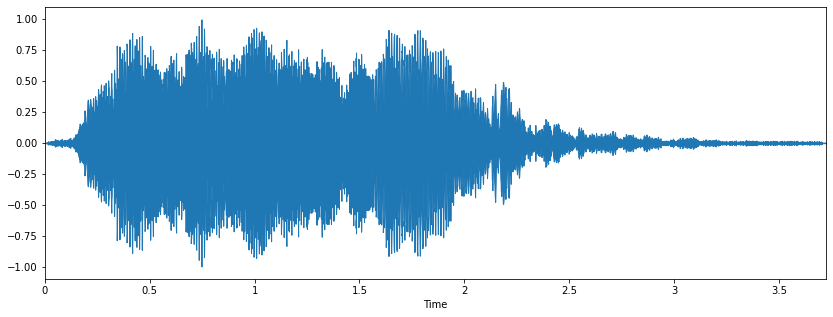

In [22]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Гудок паровоза в частотной области


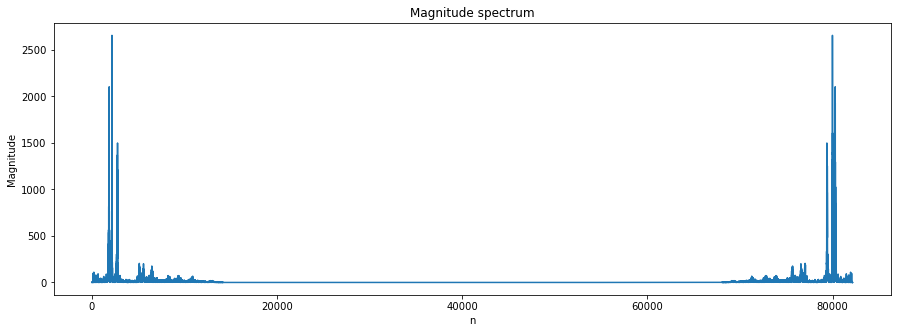

In [23]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


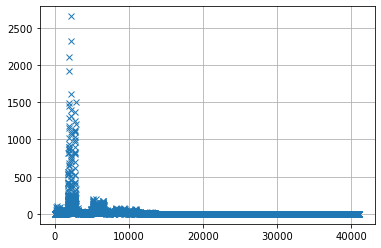

In [24]:
# определим частоту сигнала
frequencies = scipy.fftpack.fftfreq(train_whistle.shape[0], 1 / tw_sr)
frequencies = frequencies[: train_whistle.shape[0] // 2]
amplitudes = np.abs(train_whistle_spec[: train_whistle.shape[0] // 2])
peaks, _ = scipy.signal.find_peaks(amplitudes)
plt.plot(peaks, amplitudes[peaks], "x")
plt.grid(True)
plt.show()

In [25]:
def find_peaks(frequencies, amplitudes, width, lookaround):
    peak_indices = scipy.signal.find_peaks_cwt(amplitudes, widths = (width,))
    amplitudes_maxima = list(map(lambda idx: np.max(amplitudes[idx - lookaround:idx + lookaround]), peak_indices))
    frequencies_maxima = frequencies[np.isin(amplitudes, amplitudes_maxima)]
    return frequencies_maxima, amplitudes_maxima

In [26]:
frequencies_maxima, amplitudes_maxima = find_peaks(frequencies, amplitudes, 100, 50)

In [27]:
task_answer = frequencies_maxima[:3]

In [28]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer) - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")       

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

In [29]:
#YOUR CODE HERE
def sine_wave(freq, duration):
    return np.sin(np.arange(0, duration, 1 / tw_sr) * freq * 2 * np.pi) 

def compose_sine_waves(frequencies, amplitudes, duration):
    return sum(map(lambda fa: sine_wave(fa[0], 2) * fa[1], zip(frequencies, amplitudes)))

In [30]:
samples_reconstructed = compose_sine_waves(frequencies_maxima[:3], amplitudes_maxima[:3], 2)
ipd.Audio(samples_reconstructed, rate = tw_sr)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Len is 243102. Sample rate is 22050


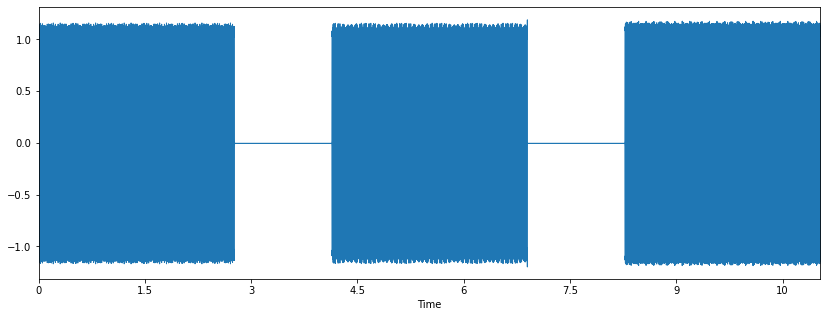

In [31]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

In [32]:
dtmf_dict = {'1': [1209, 697], '2': [1336, 697], '3': [1477, 697],
             'A': [1633, 697], '4': [1209, 770], '5': [1336, 770],
             '6': [1477, 770], 'B': [1633, 770], '7': [1209, 852],
             '8': [1336, 852], '9': [1477, 852], 'C': [1633, 852],
             '*': [1209, 941], '0': [1336, 941], '#': [1477, 941],
             'D': [1633, 941],} 

In [33]:
list_dtmf_val = [0]
for val in range(len(dtmf) - 1):
    if (dtmf[val + 1] == 0.0 and dtmf[val] != 0.0) or (dtmf[val] == 0.0 and dtmf[val + 1] != 0.0):
        list_dtmf_val.append(int(val))

list_dtmf_val = np.array(list_dtmf_val).reshape(3, 2)

In [34]:
def number_array(array, number):
    offset = 5
    for i in range(number - offset, number + offset):
        if i in array:
            return True
    return False

In [35]:
def freq_tonumber(list_dtmf_val, dtmf, dtmf_sr):
    
    phone_number = []
    for border_one, border_two in list_dtmf_val:
        dtmf_spec = np.fft.fft(dtmf[border_one:border_two], dtmf_sr)
        for i in range(len(dtmf_spec)):
            dtmf_spec[i] = int(np.absolute(dtmf_spec[i]))

        LowerBound = 20 * np.average(dtmf_spec)
        FilteredFrequencies = []
        for i in range(len(dtmf_spec)):
            if (dtmf_spec[i] > LowerBound):
                FilteredFrequencies.append(i)

        for char, frequency_pair in dtmf_dict.items():
            if (number_array(FilteredFrequencies, frequency_pair[0]) and
                number_array(FilteredFrequencies, frequency_pair[1])):
                phone_number.append(int(char))
                
    return phone_number

In [36]:
phone_number = freq_tonumber(list_dtmf_val, dtmf, dtmf_sr)

In [37]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

Correct!
